## Hierarchical topic regression model

In [1]:
using Distributions, StatsFuns, StatsBase, LogTopReg

In [2]:
σ_μ = 1.0;
σ = 0.5;
σ_β = 0.0;

n = 100;
p = 2;
nd = repeat([25],inner=[n]);
K = 3;

y = Vector{Array{Float64,2}}(n);
μ = randn(K)*σ_μ;
β = randn(K,p)*σ_β;
X = randn(p,n);
θ = [-1.5, 0.0, 1.5];
σy = 1.0;
η = Array{Float64}(K,n);
nk = Array{Int64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ + β*X[:,i];
    nk[:,i] = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = hcat(map(j -> hcat(rand(Normal(θ[j],σy),nk[j,i]),rand(Normal(θ[K:-1:1][j],σy),nk[j,i]))', 1:K)...);
end
#nk = sum(nk,2);

In [3]:
docrng = Vector{UnitRange}(n);
docrng[1] = 1:nd[1];
for i=2:n docrng[i] = (last(docrng[i-1])+1):(nd[i]+last(docrng[i-1])); end
y = hcat(y...);

In [4]:
pss0 = [deepcopy(NormalMeanPosterior(0.0,0.001,σy)) for i=1:2];
niter = 1000;
thin = 1;
ns = div(niter,thin);
hyper = hyperparameter(τ0_u = 0.01,ν0_u=0.33,ν0_σ2η=0.01,σ0_σ2η = 0.01,τ0_τ = 0.01,ν0_τ = 0.01,τ_β = 1e-6);

In [15]:
@time fit = topiclmm(y,X,docrng,pss0,K,hy=hyper,iter=niter);

 10.565029 seconds (49.84 M allocations: 4.773 GiB, 10.41% gc time)


In [13]:
using DataFrames, Gadfly

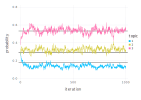

In [17]:
mudat = DataFrame(probability = mapslices(softmax,hcat(getfield.(fit.θ,:μ)...),1)[:],topic=repeat(map(string,1:K),outer=ns),
iteration=repeat(collect(1:ns),inner=K));
plot(mudat,x="iteration",y="probability",color="topic",yintercept=sum(nk,2)./sum(nk),
Geom.line,Geom.hline(color=colorant"black"))

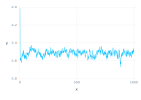

In [26]:
plot(y=getindex.(mean.(topicpd.(fit.tss))[3,:],2),x=1:niter,Geom.line)